# Лабораторная работа 5. Сверточные нейронные сети. Компьютерное зрение. Классификация изображений

В этой лабораторной работе мы с вами ненадолго отвлечемся от ваших наборов данных. Мы научились решать задачи регрессии и классификации с использованием самых разных моделей, однако во всех случаях данные были структурированными. Под структурированными данными мы понимаем данные, которые представлены в виде таблиц. В реальной жизни датасатанисты часто работают с более сложными данными - изображениями, текстами, аудиофайлами, видео и т.д.

Мы с вами будем решать задачу классификации изображений - научим машину определять, какой объект изображен на картинке. В процессе достижения этой цели мы рассмотрим особую архитектуру глубоких нейронных сетей (сверточные сети), поговорим про этапы предварительной обработки данных и познакомимся с такими вещами как перенос обучения (transfer learning) и тонкаяя настройка (fine-tuning). Начинаем!

## Кросс-корреляция и свертка

Первое, что нам нужно знать про изображения - любое изображение представимо в виде трехмерного массива (тензора). Почему так? Представьте картинку 300 на 300 пикселей - это уже матрица (двумерный массив). Третье измерение - это каналы. Большинство изображений кодируются как 3 матрицы - красный, зеленый и синий каналы соответственно (RGB). Если добавляется прозрачность - тогда имеем 4 канала (ARGB). Каждому каналу соответствует матрица, задающая интенсивность пикселя в данном канале (если у нас 8-битные изображения, то цвет кодируется числом от 0 до 255). 

Поскольку мы будем работать с матрицами, давайте введем две новые операции, которые и приведут нас к сверточным нейронным сетям

<b>Операция кросс-корреляции</b> выглядит следующим образом:

![](https://i.vgy.me/jTK6fj.gif)

На рисунке выше у нас есть исходная матрица input и к ней применяется так называемое <b>ядро (kernel)</b>. В результате взаимодействия с ядром получается матрица output. Давайте обозначать кросс-корреляцию символом ★.

Это мы сейчас с вами увидели так называемую <b>"valid" кросс-коррелцию</b>. Существует еще <b>"full" кросс-корреляция</b> (представлена ниже).

![](https://i.vgy.me/wGEFOe.png)

Есть еще <b>"same" кросс-корреляция</b>. Важная особенность - размер входной матрицы совпадает с размером выходной. Чтобы выполнить такую операцию как правило матрицу со всех сторон окружают нулями. К полученной матрице применяют уже обычную "valid" кросс-корреляцию. Все вот эти варианты операций называются <b>вариантами отступа (padding).</b>

Стоит также упомянуть, что нам при выполнении кросс-корреляции необязательно постоянно двигать ядро на 1 ячейку - можно двигать и на 2. Это конечно же повлияет на размер выходной матрицы и результат операции. Число, на которое мы делаем движения, называется <b>шагом (stride).</b>

<b>Операция свертки</b> - это та же самая кросс-корреляция, только ядро переворачивается на 180 градусов. Сравните рисунок ниже с самой первой картинкой. Операция свертки также может быть "valid", "full" и "same". Обозначать эту операцию мы будем через <b>*</b>.

![](https://i.vgy.me/W0aOxx.png)

Выполним эти операции с помощью scipy

In [1]:
from scipy import signal
import numpy as np

a = np.array([
    [4, 2, 1, 5],
    [7, 3, 2, 1],
    [5, 3, 9, 4],
    [6, 6, 8, 8]
])
kernel = np.array([
    [-0.4, 3.4],
    [2, -5]
])

# кросс-корреляция
signal.correlate2d(a, kernel, "valid"), signal.correlate2d(a, kernel, "full"), signal.correlate2d(a, kernel, "same")

(array([[  4.2,  -1.4,  15.6],
        [  2.4, -33.4,   0.6],
        [ -9.8,   1.4, -14. ]]),
 array([[-20. ,  -2. ,  -1. , -23. ,  10. ],
        [-21.4,   4.2,  -1.4,  15.6,   0. ],
        [ -1.2,   2.4, -33.4,   0.6,   7.6],
        [-13. ,  -9.8,   1.4, -14. ,  14.4],
        [ 20.4,  18. ,  24.8,  24. ,  -3.2]]),
 array([[  4.2,  -1.4,  15.6,   0. ],
        [  2.4, -33.4,   0.6,   7.6],
        [ -9.8,   1.4, -14. ,  14.4],
        [ 18. ,  24.8,  24. ,  -3.2]]))

In [2]:
# свертка
signal.convolve2d(a, kernel, "valid"), signal.convolve2d(a, kernel, "full"), signal.convolve(a, kernel, "same")

(array([[  6.6,   1.4,  11.4],
        [-13.2,  -4.4,  21. ],
        [ -1. ,  20.2, -13. ]]),
 array([[ -1.6,  12.8,   6.4,   1.4,  17. ],
        [  5.2,   6.6,   1.4,  11.4, -21.6],
        [ 12. , -13.2,  -4.4,  21. ,   8.6],
        [  7.6,  -1. ,  20.2, -13. ,   7.2],
        [ 12. , -18. , -14. , -24. , -40. ]]),
 array([[ -1.6,  12.8,   6.4,   1.4],
        [  5.2,   6.6,   1.4,  11.4],
        [ 12. , -13.2,  -4.4,  21. ],
        [  7.6,  -1. ,  20.2, -13. ]]))

## Сверточные нейронные сети (CNN)

Рассмотрим сверточные нейронные сети применительно к задаче классификации изображений. Зная, что изображения - многомерные массивы, вы без труда сможете обобщить эту архитектуру сетей под разные <b>задачи, в которых входными данными являются многомерные массивы.</b>

![](https://i.vgy.me/Ufybqw.png)

Имея изначально данные размерности 3x32x32 мы проходим через так называемый <b>сверточный слой (convolutional layer)</b>, который с помощью кросс-корреляции приводит наши данные к размерности 10x32x32. Далее имеется <b>слой понижения размерности - pooling (в данном случае MaxPooling)</b>. Схема его работы представлена ниже.

![](https://computersciencewiki.org/images/8/8a/MaxpoolSample2.png)

На практике иногда используется также AveragePooling и MinPooling.

Давайте посмотрим, как производится изменение размерности на сверточном слое. Схема вышлядит следующим образом.

![](https://i.vgy.me/VY71Pa.png)

Предположим, мы хотим перейти от размерности <b>3</b>x3x3 к <b>2</b>x2x2. Чтобы это сделать, на сверточном слое инициализируется 2*3=6 ядер, в которых содержатся веса. Ядра группируются по 3 (по первой размерности входа) и для каждой группы также создается матрица сдвига (конечно же такой же размерности, как и ядра). <b>Матрицы содержат обучаемые параметры, которые мы и будем обучать в процесе оптимизации!</b>

Прямое распространение в сверточном слое, применительно к данному примеру, производится по следующей схеме.

![](https://i.vgy.me/WhdH27.png)

![](https://i.vgy.me/VnDcFz.png)

Вспомните, что звездочкой мы обозначили операцию кросс-корреляции. Формула выше реализует "valid" кросс-корреляцию. Чтобы реализовать другие виды кросс-корреляции и управлять размером выхода нужно просто дополнять при необходимости входную матрицу нулями со всех сторон.

Обучение сети реализуется методов обратного распространения ошибки, совершенно аналогично тому, как мы это делали в многослойном персептроне. Точно также на сверточном слое вычисляются градиенты по обучаемым параметрам, а также по входу. Формулы приведены ниже.

![](https://i.vgy.me/q82jZE.png)

Архитектура сверточных нейронных сетей, как правило, предполагает наличия в конце сети обычных полносвязных слоев. Переход от сверточных слоев к полносвязным производится, как правило, с помощью "вытягивания" многомерного массива в одномерный. Такаяя операция называется выравниванием, а соответствующий переходной слой <b>выравнивающим (flatten).</b>

После изменения размерности и перехода к обычным полносвязным сетям, можно разместить на самом последнем слое нужное количество нейронов и функцию активации. Таким образом, мы можем <b> решать задачи регрессии и классификации </b> для изображений с помощью сверточных нейронных сетей.

Теперь, когда мы понимаем архитектуру сети, знаем основные параметры сверточных слоев (kernel, stride и padding) а также имеем представление о вычислениях, которые выполняются в прямом и обратном распространении, мы можем пробовать решать задачу классификации.

## Классификация изображений (собираем сеть сами)

Данные для задач классификации изображени удобно хранить по следующей структуре:
- <название папки с данными>
    - папка с названием класса 1
        - <изображение 1>
        - ...
        - <изображение n1>
      ...
    - папка с названием класса d
        - <изображение 1>
        - ...
        - <изображение nd>

Все наборы данных, с которыми мы будем работать, представлены в виде такой структуры. Загрузим данные с помощью Tensorflow.

<b>Научимся отличать самолеты от мотоциклов!</b>

In [3]:
import tensorflow as tf

При работе с изображениями удобно использовать объекты Dataset из фреймворка Tensorflow. Вот так мы можем из папки загрузить данные

In [4]:
train_ds, test_ds = tf.keras.utils.image_dataset_from_directory(
    "../data/cv/data1", # путь к изображениям
    validation_split=0.2, # процент на тест
    subset="both", # берем и обучающую и тестовую выборку
    seed=42, # сид генератора случайных чисел
    image_size=(200,400), # целевой размер изображения (СНАЧАЛА ВЫСОТА, ПОТОМ ШИРИНА)
    batch_size=32, # размер пакета (батча)
)

NotFoundError: Could not find directory ../data/cv/data1

Видим, что Tensorflow нашел наши картинки. Следует обратить внимание на такой параметр, как размер пакета (батча). Когда мы обучаем нейронные сети, у нас есть следующие основные стратегии извлечения объектов из обучающей выборки:
- брать по одному, считать predict, считать градиент, оптимизировать
- брать все сразу, считать predict для предикт, считать градиент усредненной функции потерь, оптимизировать
- брать батчами (в данном случае по 32 объекта), считать градиент усредненной функции потерь, оптимизировать

Мы создали объекты Dataset, которые по запросу будут выдавать по 32 изображения в ходе обучения и тестирования. Но мы можем и прямо сейчас посмотреть на картинки!

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
# берем один батч
for images, labels in train_ds.take(1):
    # отрисуем 9 картинок из батча
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        # выводим картинку
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        # выключаем оси (чтобы они не отображались)
        plt.axis("off")

Видим, что нам классы еще и переименовали!

Перед сборкой сети и обучением давайте скажем несколько слов о предварительной обработке данных. Применительно к картинкам, мы можем выполнять так называемые <b>аугментации</b> данных. Это полезно, когда у нас мало изображений. В качестве примера аугментаций могут быть:
- повороты изображений;
- кадрирование изображений;
- зашумление изображений и др.

Посмотрим на пример аугментации, когда мы будем случайно изменять ориентацию изображений, а также поворачивать каждое из них на случайный угл в заданном диапазоне.

In [ ]:
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.1),
    ]
)

Обратите внимание, что аугментация реализуется как два слоя. Это подтверждает нашу с вами конепцию того, что слой - это просто функция, которая преобразует x в y. Отсюда следует еще один интересный вывод - аугментации можно заранее применить ко всем изображениям, а можно встроить в саму нейронную сеть. В первом случае, обработка аугментаций будет в любом случае происходить на CPU. А во втором случае, если у вас GPU от Nvidia и установлена CUDA - обработка аугментаций будет производиться на GPU. Без GPU можно выполнять аугментации любым способом - разницы не будет.

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[i].numpy().astype("uint8"))
        plt.axis("off")

In [ ]:
# выполним аугментации для обучающих данных предварительно (1 способ)
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label)
)

Ну что же, начинаем собирать сеть для классификации изображений самолетов и мотоциклов!

In [ ]:
# входной слой - размер (200, 400, 3)
inputs = tf.keras.Input(shape=(200, 400, 3))
# преобразуем значения пикселей из [0, 255] к [0, 1]
x = tf.keras.layers.Rescaling(1.0 / 255)(inputs)
# первый сверточный слой
x = tf.keras.layers.Conv2D(64, 3, strides=2, padding="same")(x)
# первый пулинг
x = tf.keras.layers.MaxPooling2D(3, strides=2, padding="same")(x)
# второй сверточный слой
x = tf.keras.layers.Conv2D(128, 4, strides=2, padding="same")(x)
# второй пулинг
x = tf.keras.layers.MaxPooling2D(3, strides=2, padding="same")(x)
# выпрямляем многомерный массив
x = tf.keras.layers.Flatten()(x)
# полносвязный слой с 64 нейронами
x = tf.keras.layers.Dense(64, activation="relu")(x)
# выходной слой с функцией sofrmax
outputs = tf.keras.layers.Dense(2, activation="softmax")(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
model.summary()

In [ ]:
# компилируем сеть, указываем, что будем при обучении смотреть значения accuracy
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [ ]:
# начинаем обучение
# указываем validation_data - при обучении будем получать accuracy для тестовой выборки
model.fit(train_ds, epochs=5, validation_data=test_ds)

Давайте посмотрим, как можно загрузить теперь картинку и сделать предсказание.

In [ ]:
img = tf.keras.preprocessing.image.load_img(
    "../data/cv/data1/airplanes/image_0651.jpg", target_size=(200, 400)
)
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)
predictions

Вспомним, что класс 0 - это самолеты. Мы только что научились классифицировать изображения!

## Классификация изображений (transfer learning и fine-tuning)

В современном мире мы говорим о больших нейронках, которые обучены на большом количестве данных. Не каждый может позволить себе собрать датасет из миллионов картинок, чтобы обучить качественный классификатор. В этом случае, на помощь приходит transfer learning и связанный с ним fine-tuning.

<b>Токной настройкой (fine-tuning)</b> мы называем дообучение предварительно обученной нейронной сети на других данных. Представьте себе, что вы обучили сеть вчера, сохранили ее на диск. А сегодня вы проснулись с утра и решили выполнить еще несколько эпох, но уже на других данных (чтобы повысить качество модели). Это и есть transfer learning. Обычно, под transfer learning мы понимаем дообучение больших предварительно обученных моделей, которые за нас обучили такие гиганты, как OpenAI. Google и др.

Очень часто нам нужно не только дообучить сеть на новых данных, но и изменить ее выход. Например, у нас есть сеть, способная определять изображения 10 классов. Предположим, что она обучена на миллионах приммерах и показывает невероятные результаты. Но мы хотели бы, чтобы она определяла другие классы, и чтобы не 10, а 2 например. В этом случае, мы всегда можем поменять архитектуру сети - заменить выходной слой из 10 нейронов на слой из 2 нейронов. И самое главное - заморозить все слои, кроме последнего (это называется <b>feature extraction</b>). Обратите внимание, что сеть уже предварительно обучена - найдены оптимальные веса. Нам достаточно просто найти оптимальные веса для только что добавленного слоя.

Feature extraction и fine-tuning являются возможными сценариями <b>переноса обучения (transfer learning)</b>. Их можно (и желательно) комбинировать.

Стоит сказать, что часто замораживают не все слои, кроме последнего. Иногда бывает полезно разморозить один из скрытых слоев и дополнительно оптимизировать его обучаемые параметры.

Давайте возьмем предварительно обученную сверточную нейронную сеть VGG19, она есть в Tensoflow. Она была обучена на огромном датасете imagenet и может определять изображения 1000 классов. Авторами сети являются специалисты Google. Но нам не нужны это 1000 классов! Давайте научим сеть различать такие классы, как:
- аккордионы
- бабочки
- крабы

Важно: входные изображения в VGG19 имеют размер 224x224 пикселей, что можно будет увидеть в summary. Поэтому будем приводить изображения к данному размеру.

In [ ]:
# формируем датасет
train_ds, test_ds = tf.keras.utils.image_dataset_from_directory(
    "../data/cv/data2", # путь к изображениям
    validation_split=0.15, # процент на тест
    subset="both", # берем и обучающую и тестовую выборку
    seed=42, # сид генератора случайных чисел
    image_size=(224,224), # целевой размер изображения (СНАЧАЛА ВЫСОТА, ПОТОМ ШИРИНА)
    batch_size=32, # размер пакета (батча)
)

In [ ]:
plt.figure(figsize=(10, 10))
# берем один батч
for images, labels in train_ds.take(1):
    # отрисуем 9 картинок из батча
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        # выводим картинку
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        # выключаем оси (чтобы они не отображались)
        plt.axis("off")

In [ ]:
# загружаем предварительно обученную сеть VGG19
# параметр include_top со значением true указывает, что вместе со сверточными будут загружены
# полносвязные слои
vgg = tf.keras.applications.VGG19(weights='imagenet', include_top=True)
vgg.summary()

На выходном слое сети сейчас 1000 нейронов (по количеству классов). Давайте заменим его на слой из 3 нейронов.

In [ ]:
# сохраним ссылку на входной слой сети
inp = vgg.input

# создадим новый слой классификации по нашему количеству классов
new_classification_layer = tf.keras.layers.Dense(3, activation='softmax')

# соединим предпоследний слой VGG и наш новый слой классификации
out = new_classification_layer(vgg.layers[-2].output)

# создадим новую модель
model_new = tf.keras.Model(inp, out)

In [ ]:
# посмотрим, что изменилось
model_new.summary()

In [ ]:
# "заморозим" все слои, кроме последнего
for layer in model_new.layers:
    layer.trainable = False
model_new.layers[-1].trainable = True

In [ ]:
model_new.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_new.summary()

In [ ]:
model_new.fit(train_ds, epochs=5, validation_data=test_ds)

Посмотрим, что получилось

In [ ]:
img = tf.keras.preprocessing.image.load_img(
    "../data/cv/data2/crab/image_0054.jpg", target_size=(224, 224)
)
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model_new.predict(img_array)
predictions

Видим, что теперь сеть может распознавать наши классы. И делает это очень неплохо!

Transfer learning и fine-tuning сегодня используются для самых разнообразных моделей в задачах компьютерного зрений и обработки естественного языка.

## Полезные ресурсы

Объяснение архитектуры сверточных нейронных сетей на русском языке: https://www.youtube.com/watch?v=CEUNTRdLhKk&list=PLA0M1Bcd0w8yv0XGiF1wjerjSZVSrYbjh&index=16&ab_channel=selfedu 

Полный гайд по CNN: https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53


## Задание

1. Загрузите датасет для классификации кошек и собак: https://drive.google.com/file/d/1YQ2PX-BZ_7uZ216qmAnx-nTCaEqozuCZ/view?usp=share_link.
2. Загрузите датасет с множеством различных классов: https://data.caltech.edu/records/mzrjq-6wc02/files/caltech-101.zip. Выберите 3 любых класса, которые вам нравятся.
3. Загрузите данные и сформируете датасет. Выполните минимум две аугментации. Соберите сверточную нейронную сеть с помощью фреймворка Tensorflow и решите задачу классификации кошек и собак. Оцените модель. Будьте готовы ответить на вопросы:
    - какие этапы предварительной обработки данных вы делаете и что происходит с данными?
    - что означают параметры, которые вы задаете?
    - какие слои у вас есть и что происходит на каждом слое?
    
<b>Обращаю внимание: </b> допускается несдача ЛР даже если все сделано правильно, но на вопросы ответы не предоставлены (либо неверны).

4. Загрузите модели InceptionV3 и VGG19 с помощью Tensorflow. Выполните transfer learning и fine-tuning этих моделей для распознавания выбранных на 2 пункте классов. В процессе подготовки сетей, разморозьте какой-либо еще слой, кроме последнего. Сравните результаты двух сетей на ваших данных (по метрике accuracy в процессе обучения).
5. Используйте реализацию многослойного персептрона из ЛР 4. Реализуйте сверточный слой (прямое и обратное распространение). Соберите сверточную сеть. Попробуйте обучить классификатор кошек и собак с использованием собственной реализации сверточной нейронной сети. Вам также потребуется реализовать слой для преобразования многомерных массивов данных в одномерные.

## Дополнительное задание

Реализуйте слои MaxPooling, AveragePooling и MinPooling (прямое и обратное распространение). Самостоятельно найдите схему вычисления градиента.

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#1
train_CD, test_CD = tf.keras.utils.image_dataset_from_directory(
    "../data/Cats_Dogs_Dataset", # путь к изображениям
    validation_split=0.2, # процент на тест
    subset="both", # берем и обучающую и тестовую выборку
    seed=42, # сид генератора случайных чисел
    image_size=(200,400), # целевой размер изображения (СНАЧАЛА ВЫСОТА, ПОТОМ ШИРИНА)
    batch_size=32, # размер пакета (батча)
)

Found 2000 files belonging to 2 classes.
Using 1600 files for training.
Using 400 files for validation.


In [3]:
#2
train_GLP, test_GLP = tf.keras.utils.image_dataset_from_directory(
    "../data/Garfield_Leopards_Panda", # путь к изображениям
    validation_split=0.2, # процент на тест
    subset="both", # берем и обучающую и тестовую выборку
    seed=42, # сид генератора случайных чисел
    image_size=(299,299), # целевой размер изображения (СНАЧАЛА ВЫСОТА, ПОТОМ ШИРИНА)
    batch_size=32, # размер пакета (батча)
)

Found 272 files belonging to 3 classes.
Using 218 files for training.
Using 54 files for validation.


In [4]:
#3
augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.1),
        #tf.keras.layers.RandomBrightness(0.2)
    ]
)
train_ds = train_CD.map(
    lambda img, label: (augmentation(img), label)
)

inputs = tf.keras.Input(shape=(200, 400, 3))
x = tf.keras.layers.Rescaling(1.0 / 255)(inputs)
x = tf.keras.layers.Conv2D(64, 3, strides=2, padding="same")(x)
x = tf.keras.layers.MaxPooling2D(3, strides=2, padding="same")(x)
x = tf.keras.layers.Conv2D(128, 4, strides=2, padding="same")(x)
x = tf.keras.layers.MaxPooling2D(3, strides=2, padding="same")(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(64, activation="relu")(x)
outputs = tf.keras.layers.Dense(2, activation="softmax")(x)
model = tf.keras.Model(inputs, outputs)

model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

model.fit(train_CD, epochs=5, validation_data=test_CD)

Epoch 1/5
50/50 [==============================] - 88s 2s/step - loss: 1.2406 - accuracy: 0.5481 - val_loss: 0.6896 - val_accuracy: 0.5650
Epoch 2/5
50/50 [==============================] - 84s 2s/step - loss: 0.6458 - accuracy: 0.6400 - val_loss: 0.5469 - val_accuracy: 0.7075
Epoch 3/5
50/50 [==============================] - 84s 2s/step - loss: 0.5442 - accuracy: 0.7381 - val_loss: 0.5134 - val_accuracy: 0.7425
Epoch 4/5
50/50 [==============================] - 85s 2s/step - loss: 0.4904 - accuracy: 0.7688 - val_loss: 0.5663 - val_accuracy: 0.7000
Epoch 5/5
50/50 [==============================] - 85s 2s/step - loss: 0.4444 - accuracy: 0.8100 - val_loss: 0.5987 - val_accuracy: 0.7075


In [5]:
img = tf.keras.preprocessing.image.load_img(
    "../data/Cats_Dogs_Dataset/dogs/4.jpg", target_size=(200, 400)
)
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)
predictions

1/1 [==============================] - 0s 311ms/step


array([[0.11580265, 0.8841973 ]], dtype=float32)

In [6]:
#4
inception = tf.keras.applications.InceptionV3(weights='imagenet', include_top=True)
vgg = tf.keras.applications.VGG19(weights='imagenet', include_top=True)
inp_vgg = vgg.input
inp_inception = inception.input

new_classification_layer = tf.keras.layers.Dense(3, activation='softmax')
out = new_classification_layer(vgg.layers[-2].output)
model_new = tf.keras.Model(inp_vgg, out)

new_classification_layer = tf.keras.layers.Dense(3, activation='softmax')
out = new_classification_layer(inception.layers[-2].output)
model_new = tf.keras.Model(inp_inception, out)

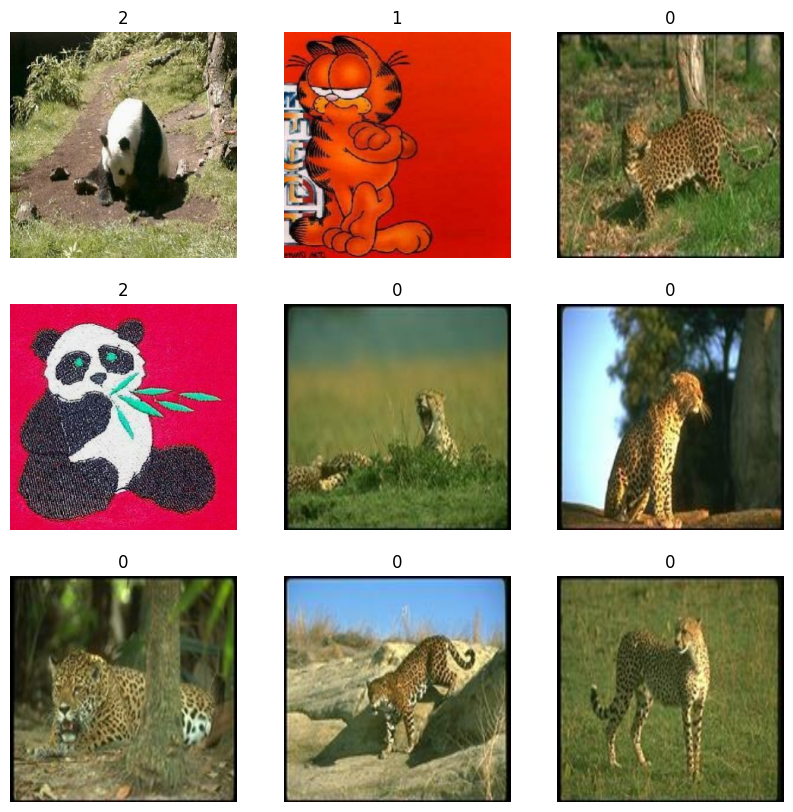

In [7]:
plt.figure(figsize=(10, 10))
# берем один батч
for images, labels in train_GLP.take(1):
    # отрисуем 9 картинок из батча
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        # выводим картинку
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        # выключаем оси (чтобы они не отображались)
        plt.axis("off")

In [8]:
for layer in model_new.layers:
    layer.trainable = False
model_new.layers[-1].trainable = True
model_new.layers[-2].trainable = True


In [9]:
model_new.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_new.fit(train_GLP, epochs=5, validation_data=test_GLP)

Epoch 1/5
7/7 [==============================] - 62s 7s/step - loss: 15.6742 - accuracy: 0.4817 - val_loss: 12.8625 - val_accuracy: 0.6667
Epoch 2/5
7/7 [==============================] - 44s 6s/step - loss: 7.2988 - accuracy: 0.5963 - val_loss: 3.0647 - val_accuracy: 0.7037
Epoch 3/5
7/7 [==============================] - 47s 7s/step - loss: 3.3329 - accuracy: 0.7569 - val_loss: 4.6378 - val_accuracy: 0.7222
Epoch 4/5
7/7 [==============================] - 47s 7s/step - loss: 1.5920 - accuracy: 0.8165 - val_loss: 1.3785 - val_accuracy: 0.8519
Epoch 5/5
7/7 [==============================] - 47s 7s/step - loss: 1.8424 - accuracy: 0.7752 - val_loss: 2.0035 - val_accuracy: 0.7778


In [10]:
###МОЕ###
def extract_data(filename, num_images, IMAGE_WIDTH):
    '''
    Extract images by reading the file bytestream. Reshape the read values into a 3D matrix of dimensions [m, h, w], where m 
    is the number of training examples.
    '''
    print('Extracting', filename)
    with gzip.open(filename) as bytestream:
        bytestream.read(16)
        buf = bytestream.read(IMAGE_WIDTH * IMAGE_WIDTH * num_images)
        data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
        data = data.reshape(num_images, IMAGE_WIDTH*IMAGE_WIDTH)
        return data

def extract_labels(filename, num_images):
    '''
    Extract label into vector of integer values of dimensions [m, 1], where m is the number of images.
    '''
    print('Extracting', filename)
    with gzip.open(filename) as bytestream:
        bytestream.read(8)
        buf = bytestream.read(1 * num_images)
        labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
    return labels


In [13]:
def convoltion(image, filt, bias, s=1):
    (n_f, n_c_f, f, _) = filt.shape
    n_c, in_dim, _ = image.shape
    out_dim = int((in_dim - f)/s)+1 
    assert n_c == n_c_f, "Dimensions of filter must match dimensions of input image"
    for curr_f in range(n_f):
        curr_y = out_y = 0
        while curr_y + f <= in_dim:
            curr_x = out_x = 0
            while curr_x + f <= in_dim:
                out[curr_f, out_y, out_x] = np.sum(filt[curr_f] * image[:,curr_y:curr_y+f, curr_x:curr_x+f]) + bias[curr_f]
                curr_x += s
                out_x += 1
            curr_y += s
            out_y += 1
    return out

In [14]:
def maxpool(image, f=2, s=2):
    n_c, h_prev, w_prev = image.shape
    h = int((h_prev - f)/s)+1 
    w = int((w_prev - f)/s)+1
    downsampled = np.zeros((n_c, h, w)) 
    
    for i in range(n_c):
        curr_y = out_y = 0
        while curr_y + f <= h_prev:
            curr_x = out_x = 0
            while curr_x + f <= w_prev:
                downsampled[i, out_y, out_x] = np.max(image[i, curr_y:curr_y+f, curr_x:curr_x+f])
                curr_x += s
                out_x += 1
            curr_y += s
            out_y += 1
    return downsampled

In [15]:
def initializeFilter(size, scale = 1.0):
    stddev = scale/np.sqrt(np.prod(size))
    return np.random.normal(loc = 0, scale = stddev, size = size)

def initializeWeight(size):
    return np.random.standard_normal(size=size) * 0.01

In [16]:
def convolutionBackward(dconv_prev, conv_in, filt, s):
    (n_f, n_c, f, _) = filt.shape
    (_, orig_dim, _) = conv_in.shape
    ## initialize derivatives
    dout = np.zeros(conv_in.shape) 
    dfilt = np.zeros(filt.shape)
    dbias = np.zeros((n_f,1))
    for curr_f in range(n_f):
        # loop through all filters
        curr_y = out_y = 0
        while curr_y + f <= orig_dim:
            curr_x = out_x = 0
            while curr_x + f <= orig_dim:
                # loss gradient of filter (used to update the filter)
                dfilt[curr_f] += dconv_prev[curr_f, out_y, out_x] * conv_in[:, curr_y:curr_y+f, curr_x:curr_x+f]
                # loss gradient of the input to the convolution operation (conv1 in the case of this network)
                dout[:, curr_y:curr_y+f, curr_x:curr_x+f] += dconv_prev[curr_f, out_y, out_x] * filt[curr_f] 
                curr_x += s
                out_x += 1
            curr_y += s
            out_y += 1
        # loss gradient of the bias
        dbias[curr_f] = np.sum(dconv_prev[curr_f])
    
    return dout, dfilt, dbias

def nanargmax(arr):
    idx = np.nanargmax(arr)
    idxs = np.unravel_index(idx, arr.shape)
    return idxs 

def maxpoolBackward(dpool, orig, f, s):
    (n_c, orig_dim, _) = orig.shape
    
    dout = np.zeros(orig.shape)
    
    for curr_c in range(n_c):
        curr_y = out_y = 0
        while curr_y + f <= orig_dim:
            curr_x = out_x = 0
            while curr_x + f <= orig_dim:
                # obtain index of largest value in input for current window
                (a, b) = nanargmax(orig[curr_c, curr_y:curr_y+f, curr_x:curr_x+f])
                dout[curr_c, curr_y+a, curr_x+b] = dpool[curr_c, out_y, out_x]
                
                curr_x += s
                out_x += 1
            curr_y += s
            out_y += 1
        
    return dout


In [17]:
#Реализация

def relu(Z):
    return np.maximum(0, Z)

def leaky_relu(Z):
    return np.maximum(0.5*Z, Z)

def sigmoid(Z):
    return 1/(1+np.exp(-Z))

def softmax(Z):
    return out/np.sum(np.exp(Z))

def maxpool(image, f=2, s=2):
    n_c, h_prev, w_prev = image.shape
    h = int((h_prev - f)/s)+1 
    w = int((w_prev - f)/s)+1
    downsampled = np.zeros((n_c, h, w)) 
    
    for i in range(n_c):
        curr_y = out_y = 0
        while curr_y + f <= h_prev:
            curr_x = out_x = 0
            while curr_x + f <= w_prev:
                downsampled[i, out_y, out_x] = np.max(image[i, curr_y:curr_y+f, curr_x:curr_x+f])
                curr_x += s
                out_x += 1
            curr_y += s
            out_y += 1
    return downsampled


class ConvolutionalLayer:
    def __init__(self, size, scale = 1.0):
        self.size = size
        self.scale = scale
        
    def initialize(self, prev_layer, optimizer):
        stddev = scale/np.sqrt(np.prod(size))
        self.filt = np.random.normal(loc = 0, scale = stddev, size = size)
        self.b = np.zeros(([0],1))

    def forward_layer(self, image, label, conv_s, prev_layer):
        self.A = convolution(prev_layer.A, self.filt, self.b, conv_s)
        self.A[self.conv<=0] = 0
        
    def backward_layer(self, prev_layer):
        self.dA[self.A<=0] = 0
        prev_layer.dA, self.dfilt, self.db = convolutionBackward(self.dA, prev_layer.image, self.filt, self.stride)
            
class Layer:
    def __init__(self, dim, activation):
        self.dim = dim
        self.activation = activation
        
    def initialize(self, prev_layer, optimizer):
        self.W = np.random.randn(self.dim, prev_layer.dim) / np.sqrt(prev_layer.dim) * 0.1
        self.b = np.zeros((self.dim, 1))
        if optimizer == 'ADAM':
            self.s_dW = np.zeros((self.dim, 1))
            self.s_db = np.zeros((self.dim, 1))
            self.v_dW = np.zeros((self.dim, 1))
            self.v_db = np.zeros((self.dim, 1))
    
    def forward_layer(self, prev_layer):
        if not isinstance(prev_layer, Layer):
            (nf2, dim2, _) = prev_layer.image.shape
            #не лучшее решение
            prev_layer.A = prev_layer.image.reshape((nf2 * dim2 * dim2, 1))
    
        if self.activation == 'relu':
            self.Z = self.W.dot(prev_layer.A) + self.b
            self.A = relu(self.Z)
        elif self.activation == 'sigmoid':
            self.Z = self.W.dot(prev_layer.A) + self.b
            self.A = sigmoid(self.Z)
        elif self.activation == 'leaky_relu':
            self.Z = self.W.dot(prev_layer.A) + self.b
            self.A = leaky_relu(self.Z)
        elif self.activation == 'linear':
            self.Z = self.W.dot(prev_layer.A) + self.b
            self.A = self.Z
        elif self.activation == 'softmax':
            self.Z = self.W.dot(prev_layer.A) + self.b
            self.A = softmax(self.Z)
    
    def backward_layer(self, prev_layer):
        if self.activation == 'relu':
            self.dZ = np.array(self.dA, copy=True)
            self.dZ[self.Z <= 0] = 0
            self.dW = 1./prev_layer.dim * np.dot(self.dZ, prev_layer.A.T)
            self.db = 1./prev_layer.dim * np.sum(self.dZ, axis = 1, keepdims = True)
            prev_layer.dA = np.dot(self.W.T,self.dZ)
        elif self.activation == 'sigmoid':
            s = 1/(1+np.exp(-self.Z))
            self.dZ = self.dA * s * (1-s)

            self.dW = 1./prev_layer.dim * np.dot(self.dZ, prev_layer.A.T)
            self.db = 1./prev_layer.dim * np.sum(self.dZ, axis = 1, keepdims = True)
            prev_layer.dA = np.dot(self.W.T,self.dZ)
        elif self.activation == 'leaky_relu':
            self.dZ = np.array(self.dA, copy=True)
            self.dZ[self.Z <= 0] = 0.5
            
            self.dW = 1./prev_layer.dim * np.dot(self.dZ, prev_layer.A.T)
            self.db = 1./prev_layer.dim * np.sum(self.dZ, axis = 1, keepdims = True)
            prev_layer.dA = np.dot(self.W.T,self.dZ)
        elif self.activation == 'linear':
            self.dZ = np.array(self.dA, copy=True)
            self.dW = 1./prev_layer.dim * np.dot(self.dZ, prev_layer.A.T)
            self.db = 1./prev_layer.dim * np.sum(self.dZ, axis = 1, keepdims = True)
            prev_layer.dA = np.dot(self.W.T,self.dZ)

            
class MaxpoolLayer:
    def __init__(self, filt, stride):
        self.filt = filt
        selt.stride = stride
        
    def initialize(self, prev_layer, optimizer):
        self.prev_layer = prev_layer
        
    def forward_layer(self, prev_layer):
        self.image = maxpool(self.prev_layer.conv, self.filt, pool_s)
        
    def backward_layer(self, prev_layer):
        self.dpool = self.dA.reshape(self.image.shape)
        prev_layer.dA = maxpoolBackward(self.dpool, prev_layer.image, self.filt, self.stride)

class Model:
    def __init__(self, layers, cost, optimizer = 'default', opt_params={}):
        self.layers = layers
        self.layers_num = len(layers)
        for l in range(1, self.layers_num):
            self.layers[l].initialize(self.layers[l-1], optimizer)
        self.cost_type = cost
        self.optimizer = optimizer
        self.opt_params = opt_params
                
    def forward(self, X):
        self.layers[0].A = X
        for l in range(1, self.layers_num):
            self.layers[l].forward_layer(self.layers[l-1])
        return self.layers[-1].A
           
    def cost(self, AL, Y):
        if self.cost_type == 'mse':
            cost = 1/Y.shape[1]*np.sum(np.power((AL-Y), 2))
        elif self.cost_type == 'cross_entropy':
            cost = -np.sum(Y * np.log(AL))
        return np.squeeze(cost)
        
    def backward(self, AL, Y):
        if self.cost_type == 'mse':
            self.layers[-1].dA = 2/Y.shape[1] * (AL-Y)
        elif self.cost_type == 'cross_entropy':
            self.layers[-1].dA = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
        
            
        for l in reversed(range(1, self.layers_num)):
            self.layers[l].backward_layer(self.layers[l-1])
    
    def update_default(self, learning_rate):
        for l in range(1, self.layers_num):
            self.layers[l].W = self.layers[l].W - learning_rate*self.layers[l].dW
            self.layers[l].b = self.layers[l].b - learning_rate*self.layers[l].db
                
    def update_ADAM(self, learning_rate, opt_params, t):
        for l in range(1, self.layers_num):
            self.layers[l].v_dW = opt_params['beta1'] * self.layers[l].v_dW + (1 - opt_params['beta1']) * self.layers[l].dW
            self.layers[l].v_db = opt_params['beta1'] * self.layers[l].v_db + (1 - opt_params['beta1']) * self.layers[l].db

            v_corrected_dW = self.layers[l].v_dW / (1 - np.power(opt_params['beta1'], t)
            v_corrected_db = self.layers[l].v_db / (1 - np.power(opt_params['beta1'], t)
            
            self.layers[l].s_dW = opt_params['beta2'] * self.layers[l].s_dW + (1 - opt_params['beta2']) * np.power(self.layers[l].dW, 2)
            self.layers[l].s_db = opt_params['beta2'] * self.layers[l].s_db + (1 - opt_params['beta2']) * np.power(self.layers[l].db, 2)

            s_corrected_dW = self.layers[l].s_dW / (1 - np.power(opt_params['beta2'], t)
            s_corrected_db = self.layers[l].s_db / (1 - np.power(opt_params['beta2'], t)
            
            self.layers[l].W = self.layers[l].W - learning_rate * v_corrected_dW / (np.sqrt( s_corrected_dW )+ pow(10,-8))
            self.layers[l].b = self.layers[l].b - learning_rate * v_corrected_db / (np.sqrt( s_corrected_db )+ pow(10,-8))

        
    def fit(self, X, Y, num_epochs=2, learning_rate = 0.1):
        X = extract_data('train-images-idx3-ubyte.gz', m, img_dim)
        Y = np.array(Y)
        Y = Y.reshape((1, len(Y)))
        for i in range(max_iterations):
            AL = self.forward(X)
            cost = self.cost(AL, Y)
            self.backward(AL, Y)
            
            if self.optimizer == 'default':
                self.update_default(learning_rate)
            elif self.optimizer == 'RMSP':
                self.update_RMSP(learning_rate, self.opt_params)
            elif self.optimizer == 'ADAM':
                self.update_RMSP(learning_rate, self.opt_params, i)
    
    def predict(self, X):
        X = X.T
        pred = self.forward(X)
        return pred.T
        

SyntaxError: invalid syntax. Perhaps you forgot a comma? (2096540239.py, line 174)